# Table of Contents:
* [0 -Importing Libraries](#0)
* [1 - Read in df](#1)
* [2 - SIR](#2)
* [3 - Descriptive Facts](#3)
* [4 - Prepare the dfset (change in turnout)](#4)
* [5 - Regressions](#5)

# 0) Imports <a class="anchor" id="0"></a>

In [148]:
import pandas as pd
import numpy as np
from numpy import nan
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import ast  
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# 1) Read in df <a class="anchor" id="1"></a>

In [149]:
txt_file = 'medium.txt'

In [150]:
# Initialize an empty list to store the df
df = []

# Define keys based on the train_train_train_train_train_dfset format
keys = ['#*', '#@', '#t', '#c', '#index', '#%', '#!']

# Open the file and read the contents
with open(txt_file, 'r', encoding='ISO-8859-1') as file:
    current_paper = {}
    for line in file:
        line = line.strip()
        if line.startswith('#*'):
            # New paper starts; save the previous one if it exists
            if current_paper:
                df.append(current_paper)
                current_paper = {}
            current_paper['Title'] = line[2:].strip()
        elif line.startswith('#@'):
            current_paper['Authors'] = line[2:].strip()
        elif line.startswith('#t'):
            current_paper['Year'] = line[2:].strip()
        elif line.startswith('#c'):
            current_paper['Venue'] = line[2:].strip()
        elif line.startswith('#index'):
            current_paper['Index ID'] = line[6:].strip()
        elif line.startswith('#%'):
            if 'References' not in current_paper:
                current_paper['References'] = []
            current_paper['References'].append(line[2:].strip())
        elif line.startswith('#!'):
            current_paper['Abstract'] = line[2:].strip()
        elif line.isdigit() and current_paper:  # Handle end of current paper
            df.append(current_paper)
            current_paper = {}
    # Add the last paper
    if current_paper:
        df.append(current_paper)

# Convert list of dicts to dfFrame
df = pd.DataFrame(df)

# Replacing missing keys with None which becomes NaN in dfFrame
for key in ['Title', 'Authors', 'Year', 'Venue', 'Index ID', 'References', 'Abstract']:
    if key not in df.columns:
        df[key] = None

In [153]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df[(df['Year']>1930) & (df['Year']<2010)]
df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')
# Apply the function to the dfFrame column
df['References'] = df['References'].apply(
    lambda x: [int(i) for i in x] if isinstance(x, list) else x
)

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\34658713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')
C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\34658713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['References'] = df['References'].apply(


Last Cited Year (for SIR)

In [154]:
# Creating a dictionary from the dfFrame assuming 'Index ID' and 'Year' are columns in your dfFrame
year_dict = df.set_index('Index ID')['Year'].to_dict()

def get_last_cited_year(ref_ids):
    if not isinstance(ref_ids, list):
        return np.nan
    # Filter and collect years where reference IDs exist in year_dict
    years = [year_dict.get(int(ref_id)) for ref_id in ref_ids if int(ref_id) in year_dict]
    return max(years) if years else np.nan

# Apply the function to the 'References' column to compute the 'Last Cited Year'
df['Last Cited Year'] = df['References'].apply(get_last_cited_year)
df["Venue"] = df["Venue"].astype(str)
df['Venue'] = df['Venue'].replace('', np.nan)
df["References Count"] = df["References"].apply(lambda x: len(x) if isinstance(x, list) else 0)

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\2852157099.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Last Cited Year'] = df['References'].apply(get_last_cited_year)
C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\2852157099.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Venue"] = df["Venue"].astype(str)
C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\2852157099.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [155]:
# Calculate total authors
df['Authors'] = df['Authors'].fillna('')  # Fill empty strings where there are no authors
unique_authors = set()
df['Authors'].apply(lambda x: unique_authors.update(x.split(',')) if x else None)
total_authors = len(unique_authors) - 1 if '' in unique_authors else len(unique_authors)

# Fill missing Venue values with "Unknown"
df['Venue'] = df['Venue'].fillna("Unknown")

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\3974917888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Authors'] = df['Authors'].fillna('')  # Fill empty strings where there are no authors
C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\3974917888.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Venue'] = df['Venue'].fillna("Unknown")


In [156]:
df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')

# Convert 'References' from string representation of list to actual list
def safe_eval(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return []  # Return an empty list if there's any error

df['References'] = df['References'].apply(safe_eval)

# Creating a dictionary of publication years for quick lookup
publication_years = df.set_index('Index ID')['Year'].to_dict()

# Function to count citations within three years
def count_citations_within_3_years(row):
    if isinstance(row['References'], list):  # Ensure that the data is list
        citation_years = [publication_years.get(int(ref)) for ref in row['References'] if publication_years.get(int(ref)) is not None]
        return sum((year is not None and (row['Year'] <= year <= row['Year'] + 3)) for year in citation_years)
    return 0  # Return 0 if References is not a list

# Apply the function
df['citation_count_within_3_years'] = df.apply(count_citations_within_3_years, axis=1)

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\2821567953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Index ID'] = pd.to_numeric(df['Index ID'], errors='coerce')
C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\2821567953.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['References'] = df['References'].apply(safe_eval)
C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_996\2821567953.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [205]:
df.iloc[0]["References"][0]

776808

In [214]:
# Define the high-impact venues
high_impact_venues = [
    "Nature",
    "Science",
    "IEEE Transactions on Information Forensics and Security",
    "Journal of Machine Learning Research",
    "Communications of the ACM",
    "IEEE Transactions on Knowledge and Data Engineering",
    "Journal of the ACM",
    "Proceedings of the IEEE",
    "ACM Transactions on Algorithms",
    "IEEE Trans. Parallel Distrib. Syst.",
    "IEEE Trans. Evolutionary Computation",
    "Journal of Computational Physics",
    "Journal of the American Society for Information Science and Technology"
]

# Function to check if the venue is high-impact
def is_high_impact(venue):
    if any(high in venue for high in high_impact_venues):
        return True
    return False

high_impact_threshold = 5  # From online

# Ensure each paper is in one state using the revised criteria
def classify_paper(row):
    if isinstance(row['References'], list) and row['citation_count_within_3_years'] >= high_impact_threshold:
        return 'EXPOSED'
    elif isinstance(row['References'], list):
        return 'CITING'
    elif pd.notna(row['Last Cited Year']) or (df['Year'].max() - row['Last Cited Year'] >= 5):
        return 'ARCHIVED'
    return 'UNLINKED'  # default, might indicate data issues or unclassifiable papers

df['State'] = df.apply(classify_paper, axis=1)

In [213]:
# Count the occurrences of each state
state_counts = df['State'].value_counts()
print(state_counts)

State
UNKNOWN    1117823
CITING      296377
EXPOSED        990
Name: count, dtype: int64


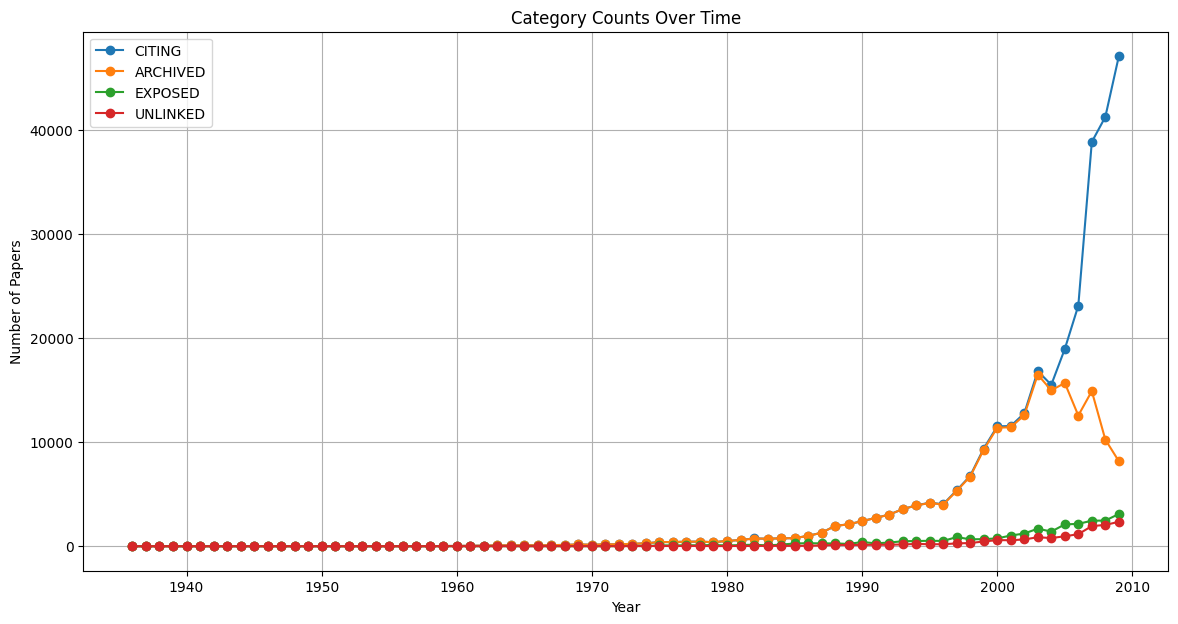

In [190]:
# Group by year and count each category within 'State'
yearly_data = df.groupby('Year')['State'].value_counts().unstack(fill_value=0).reset_index()

# Plotting
plt.figure(figsize=(14, 7))
for state in ['CITING', 'ARCHIVED', 'EXPOSED', 'UNLINKED', 'PENDING']:
    if state in yearly_data:
        plt.plot(yearly_data['Year'], yearly_data[state], label=state, marker='o')

plt.title('Category Counts Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.legend()
plt.grid(True)
plt.show()

# 2) PACEU model <a class="anchor" id="2"></a>

In [191]:
# Reset index
df = df.sample(frac=1).reset_index(drop=True)

In [192]:
min_year = 2000
test_year = 2007
max_year = 2009

In [193]:
# Time-based split
train_df = df[(df['Year'] <= test_year) & (df['Year'] > min_year)]
test_df = df[df['Year'] > test_year]

## 2.1) Define intial conditions

K=187786.05056373033, P0=54863.80626898125, r=0.30702068173109276


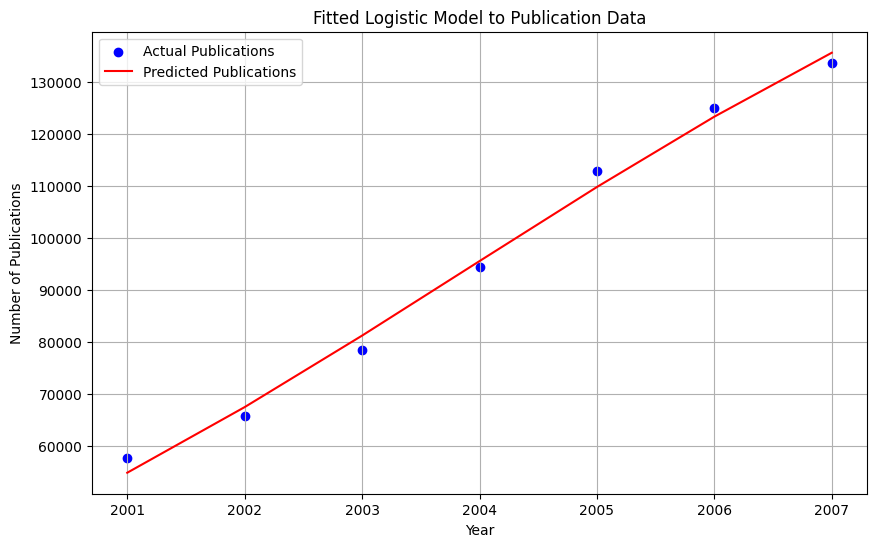

In [194]:
# Count publications per year within the training set
year_counts = train_df['Year'].value_counts().sort_index()

# Prepare data for the model fitting
x_data = year_counts.index.values
y_data = year_counts.values

# Initial guesses for parameters
P0_initial = y_data[0]  # Initial population size (publications in the first year of training data)
K_initial = y_data[-1] * 1.5  # Assume carrying capacity is a bit higher than the last observed data point
r_initial = 0.1  # Initial guess for the growth rate

# Logistic growth model function
def logistic_model(x, K, P0, r):
    return K / (1 + ((K - P0) / P0) * np.exp(-r * (x - x.min())))

# Fit the logistic model to the training data
logistics_params, cov = curve_fit(logistic_model, x_data, y_data, p0=[K_initial, P0_initial, r_initial], maxfev=10000)
K, P0, r = logistics_params

print(f'Logistic Model Parameters: K={K:.2f}, P0={P0:.2f}, r={r:.4f}')

# Plot fitted logistic model and actual data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='Actual Publications')
plt.plot(x_data, logistic_model(x_data, *logistics_params), color='red', label='Predicted Publications')
plt.title('Fitted Logistic Model to Publication Data')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.grid(True)
plt.show()

In [195]:
def citation_model(y, t, lambda_, beta, gamma):
    P, E, C, A = y
    dP_dt = -lambda_ * P  # Rate at which papers move from PENDING to EXPOSED
    dE_dt = lambda_ * P - beta * E  # New papers becoming EXPOSED minus EXPOSED papers moving to CITING
    dC_dt = beta * E - gamma * C  # EXPOSED papers moving to CITING minus CITING papers becoming ARCHIVED
    dA_dt = gamma * C  # CITING papers becoming ARCHIVED
    return [dP_dt, dE_dt, dC_dt, dA_dt]

In [196]:
def calculate_parameters(train_df, min_year):
    # Ensure only relevant data is used and filter out 'UNLINKED' papers
    train_df = train_df[(train_df['Year'] >= min_year) & (train_df['UNLINKED'] == False)]
    
    # Initialize lists to store yearly transition rates
    lambda_vals, beta_vals, gamma_vals = [], [], []

    # Iterate through each year to calculate rates based on year-on-year changes
    for year in range(int(train_df['Year'].min()), int(train_df['Year'].max())):
        exposed_previous_year = train_df[train_df['Year'] == year - 1]['EXPOSED'].sum()
        citing_previous_year = train_df[train_df['Year'] == year - 1]['CITING'].sum()

        new_exposed = train_df[train_df['Year'] == year]['EXPOSED'].sum() - exposed_previous_year
        new_citing = train_df[train_df['Year'] == year]['CITING'].sum() - citing_previous_year
        new_archived = train_df[train_df['Year'] == year]['ARCHIVED'].sum() - train_df[train_df['Year'] - 1]['ARCHIVED'].sum()

        total_papers = train_df[train_df['Year'] == year - 1].shape[0]

        # Calculate parameters based on conditions
        if total_papers > 0:
            lambda_vals.append(new_exposed / total_papers)
        if exposed_previous_year > 0:
            beta_vals.append(new_citing / exposed_previous_year)
        if citing_previous_year > 0:
            gamma_vals.append(new_archived / citing_previous_year)

    # Calculate average transition rates
    lambda_ = np.mean(lambda_vals) if lambda_vals else 0
    beta = np.mean(beta_vals) if beta_vals else 0
    gamma = np.mean(gamma_vals) if gamma_vals else 0

    return lambda_, beta, gamma

# Apply function to calculate parameters
lambda_, beta_, gamma_ = calculate_parameters(train_df, min_year)
params = (lambda_, beta_, gamma_)
print(f"Citation Model Parameters: λ={lambda_:.4f}, β={beta_:.4f}, γ={gamma_:.4f}")

Parameters: (0.0029224732930014665, 1.5630629520272312, 0.039510994091312174)


## 2.2) 

RMSE Exposed: 1608.229638004007
RMSE Citing: 11514.599426111945
RMSE Archived: 1936.2558066344545


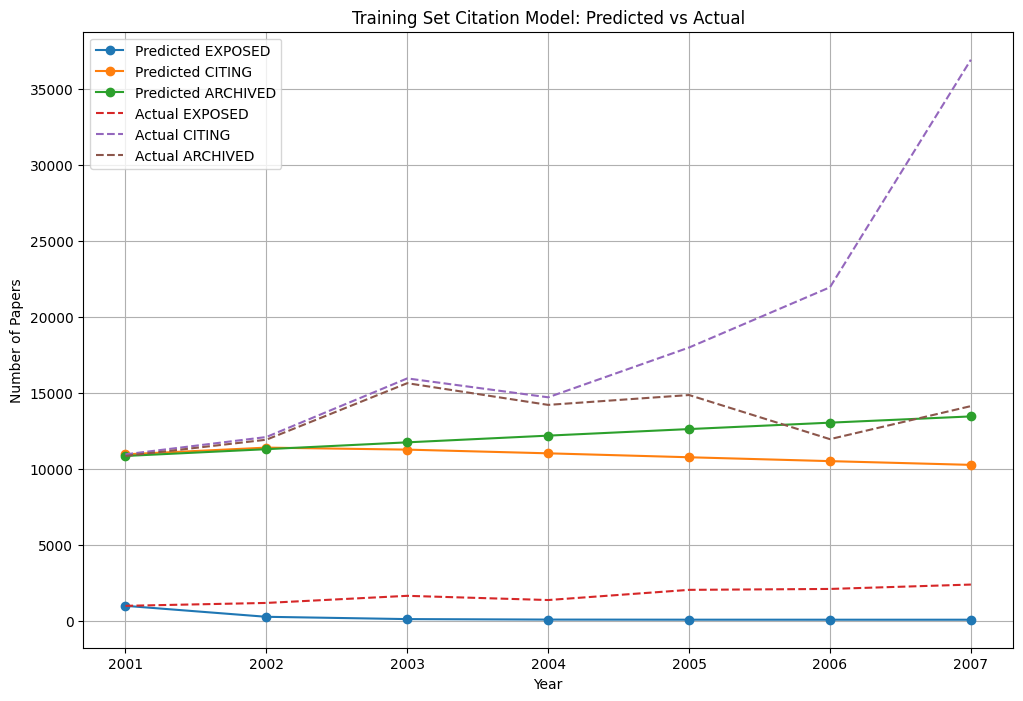

In [197]:
def run_simulation_and_plot(df, min_year, max_year, logistic_params, paceu_params, title):
    # Filter the dataset for the relevant years and exclude 'UNLINKED' papers
    df = df[(df['Year'] >= min_year) & (df['Year'] <= max_year) & (df['UNLINKED'] == False)]
    
    # Gather actual 'PENDING' papers data using publication counts per year
    year_counts = df['Year'].value_counts().sort_index()
    x_data = year_counts.index.values
    y_data = year_counts.values
    actual_pending = y_data
    
    # Logistic parameters for predicting 'PENDING' papers
    K, P0, r = logistic_params
    
    # Define the logistic growth function for dynamic 'PENDING' papers generation
    def logistic_growth(t, P):
        return r * P * (1 - P / K)

    # Solve the logistic growth model from the minimum to maximum year
    solution = solve_ivp(logistic_growth, [min(x_data), max(x_data)], [P0], t_eval=np.linspace(min(x_data), max(x_data), len(x_data)))
    
    # Predicted 'PENDING' papers
    predicted_pending = solution.y.flatten()
    
    # Initial conditions for other states based on the first available year data
    E0 = df[df['Year'] == min(x_data)]['EXPOSED'].sum()
    C0 = df[df['Year'] == min(x_data)]['CITING'].sum()
    A0 = df[df['Year'] == min(x_data)]['ARCHIVED'].sum()
    
    # Initial conditions for the simulation
    initial_conditions = [actual_pending[0], E0, C0, A0]
    
    # Simulation time points
    time_points = np.linspace(min(x_data), max(x_data), num=len(x_data))
    
    # Parameters for the citation model
    lambda_, beta, gamma = paceu_params
    
    # Run the ODE solver
    results = odeint(citation_model, initial_conditions, time_points, args=(lambda_, beta, gamma))
    
    # Gather actual data for comparison
    actual_data = [[actual_pending[i], 
                    df[df['Year'] == year]['EXPOSED'].sum(),
                    df[df['Year'] == year]['CITING'].sum(),
                    df[df['Year'] == year]['ARCHIVED'].sum()] for i, year in enumerate(x_data)]

    # Calculate separate RMSE for each category
    rmse_exposed = np.sqrt(mean_squared_error(np.array(actual_data)[:, 1], results[:, 1]))
    rmse_citing = np.sqrt(mean_squared_error(np.array(actual_data)[:, 2], results[:, 2]))
    rmse_archived = np.sqrt(mean_squared_error(np.array(actual_data)[:, 3], results[:, 3]))

    print(f"RMSE Exposed: {rmse_exposed:.2f}")
    print(f"RMSE Citing: {rmse_citing:.2f}")
    print(f"RMSE Archived: {rmse_archived:.2f}")

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(time_points, results[:, 1:], marker='o')
    plt.plot(time_points, np.array(actual_data)[:, 1:], linestyle='--')
    plt.title(f'{title}: Predicted vs Actual')
    plt.xlabel('Year')
    plt.ylabel('Number of Papers')
    plt.legend(['Predicted EXPOSED', 'Predicted CITING', 'Predicted ARCHIVED', 
                'Actual EXPOSED', 'Actual CITING', 'Actual ARCHIVED'], loc='upper left')
    plt.grid(True)
    plt.show()

    return

# Execute the simulation and plotting function
train_rmse = run_simulation_and_plot(train_df, min_year, test_year, logistics_params, params, 'Training Set Citation Model')

RMSE Exposed: 393.907314267526
RMSE Citing: 2287.471045359513
RMSE Archived: 46.163512313279405


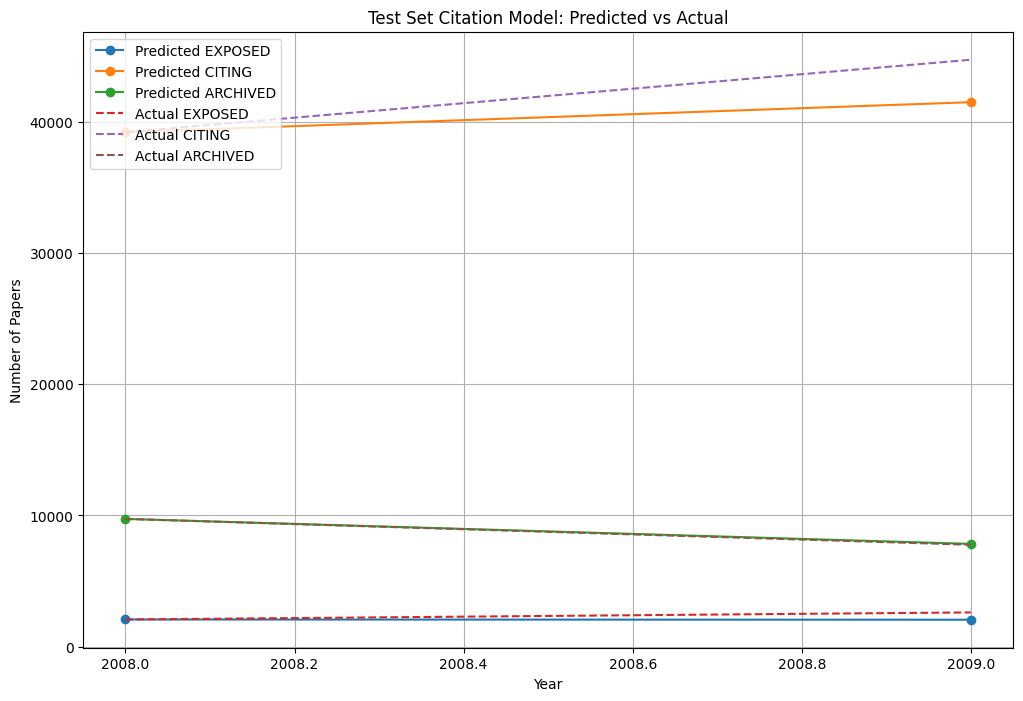

In [176]:
# Update calls to simulation function
test_rmse = run_simulation_and_plot(test_df, test_year, max_year, logistics_params, params, 'Test Set Citation Model')

## Sensitivity Analsysis